In [1]:
import skmob
from skmob.models import Gravity
import geopandas as gpd
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
np.random.seed(0)

ImportError: cannot import name 'Gravity' from 'skmob.models' (C:\Users\10169\anaconda3\envs\bda_traff\lib\site-packages\skmob\models\__init__.py)

In [5]:
import skmob

In [8]:
skmob.models


<module 'skmob.models' from 'C:\\Users\\10169\\anaconda3\\envs\\bda_traff\\lib\\site-packages\\skmob\\models\\__init__.py'>

In [2]:
CSA_df = pd.read_csv('CSA_df.csv')
CSA_df.head()

,Airport,lat,lon,state,state_code,city,CSA_Name
0,ATL,33.640833,-84.427222,Georgia,GA,Atlanta,"Atlanta--Athens-Clarke County--Sandy Springs, ..."
1,BOS,42.363611,-71.006111,Massachusetts,MA,Boston,"Boston-Worcester-Providence, MA-RI-NH-CT"
2,CLT,35.219167,-80.935833,North Carolina,NC,Charlotte,"Charlotte-Concord, NC-SC"
3,CHI,41.881528,-87.829028,Illinois,IL,Chicago,"Chicago-Naperville, IL-IN-WI"
4,DFW,32.894444,-97.029722,Texas,TX,Dallas/Fort Worth,"Dallas-Fort Worth, TX-OK"


In [3]:
us_CSA = gpd.read_file('us_CSA.shp')
met = us_CSA[us_CSA['if_plot']==1]

In [4]:
met = met[['TotPop', 'CSA_Name', 'geometry']]
met = met.merge(right=CSA_df[['Airport', 'CSA_Name']], left_on='CSA_Name', right_on='CSA_Name')
met = met.rename(columns={'Airport': 'tile_ID', 'TotPop': 'population'}).sort_values(by='tile_ID')
tess = gpd.GeoDataFrame(met[['tile_ID', 'population']], geometry=met['geometry'], crs='EPSG:4326')
tess.head()

,tile_ID,population,geometry
0,ATL,6584708,"POLYGON ((-85.16585 32.80850, -85.16563 32.808..."
6,BOS,8200935,"MULTIPOLYGON (((-71.88392 41.32650, -71.88213 ..."
12,CHI,9907569,"POLYGON ((-88.34208 41.11209, -88.34404 41.112..."
16,CLT,2656704,"POLYGON ((-81.42300 34.58677, -81.42269 34.587..."
5,DEN,3466374,"POLYGON ((-105.97241 38.89926, -105.97162 38.8..."


In [5]:
OD = pd.read_csv('201904_OD_CSA.csv', index_col=0)
OD.head()

,ATL,BOS,CLT,DEN,DFW,DTW,HNL,IAH,LAS,LAX,...,PHL,PHX,SAN,SEA,SFO,SLC,TPA,CHI,NYC,WAS
ATL,0.0,14164.0,2612.0,12058.0,12241.0,9195.0,1427.0,7834.0,11396.0,15830.0,...,11572.0,6964.0,4220.0,6052.0,7953.0,4235.0,10660.0,22147.0,45042.0,28980.0
BOS,14116.0,0.0,7127.0,9950.0,8547.0,6668.0,1551.0,4643.0,7215.0,16494.0,...,12129.0,6130.0,6138.0,6898.0,16984.0,3134.0,9766.0,21849.0,22648.0,31253.0
CLT,2673.0,7240.0,0.0,4937.0,5100.0,3464.0,294.0,3211.0,4747.0,3983.0,...,5923.0,3155.0,1830.0,1746.0,3179.0,1375.0,2959.0,6747.0,24802.0,11643.0
DEN,11930.0,9963.0,4792.0,0.0,12312.0,7846.0,1980.0,9661.0,15964.0,18762.0,...,8293.0,19731.0,11205.0,12211.0,14066.0,8969.0,7126.0,22379.0,22049.0,19911.0
DFW,12405.0,8695.0,5190.0,12330.0,0.0,7033.0,1654.0,3933.0,12232.0,17838.0,...,8558.0,7940.0,5263.0,6984.0,8023.0,4770.0,4706.0,18102.0,26112.0,13278.0


In [6]:
ODa = OD.stack().reset_index().set_axis(['origin', 'destination', 'flow'], axis=1)
ODa = ODa.sort_values(by=['origin', 'destination'])
fdf = skmob.FlowDataFrame(ODa, origin='origin', destination='destination', flow='flow', tessellation=tess,
                          tile_id='tile_ID')

In [7]:
tot_outflows = fdf[fdf['origin']!=fdf['destination']].groupby(by='origin', axis=0)[['flow']].sum()
tess = tess.merge(tot_outflows, left_on='tile_ID', right_on='origin').rename(columns={'flow': 'tot_outflow'})
tess.head()

,tile_ID,population,geometry,tot_outflow
0,ATL,6584708,"POLYGON ((-85.16585 32.80850, -85.16563 32.808...",285674.0
1,BOS,8200935,"MULTIPOLYGON (((-71.88392 41.32650, -71.88213 ...",256955.0
2,CHI,9907569,"POLYGON ((-88.34208 41.11209, -88.34404 41.112...",412603.0
3,CLT,2656704,"POLYGON ((-81.42300 34.58677, -81.42269 34.587...",119230.0
4,DEN,3466374,"POLYGON ((-105.97241 38.89926, -105.97162 38.8...",279690.0


In [8]:
ODb = ODa.pivot(index='origin', columns='destination', values='flow')
ODb.head()

destination,ATL,BOS,CHI,CLT,DEN,DFW,DTW,HNL,IAH,LAS,...,MSP,NYC,PHL,PHX,SAN,SEA,SFO,SLC,TPA,WAS
origin,,,,,,,,,,,,,,,,,,,,,
ATL,0.0,14164.0,22147.0,2612.0,12058.0,12241.0,9195.0,1427.0,7834.0,11396.0,...,6321.0,45042.0,11572.0,6964.0,4220.0,6052.0,7953.0,4235.0,10660.0,28980.0
BOS,14116.0,0.0,21849.0,7127.0,9950.0,8547.0,6668.0,1551.0,4643.0,7215.0,...,6875.0,22648.0,12129.0,6130.0,6138.0,6898.0,16984.0,3134.0,9766.0,31253.0
CHI,22189.0,22073.0,0.0,6918.0,22269.0,18006.0,6983.0,2298.0,10813.0,20312.0,...,16786.0,55294.0,13646.0,21368.0,11045.0,11580.0,18185.0,4533.0,15983.0,29763.0
CLT,2673.0,7240.0,6747.0,0.0,4937.0,5100.0,3464.0,294.0,3211.0,4747.0,...,3084.0,24802.0,5923.0,3155.0,1830.0,1746.0,3179.0,1375.0,2959.0,11643.0
DEN,11930.0,9963.0,22379.0,4792.0,0.0,12312.0,7846.0,1980.0,9661.0,15964.0,...,13724.0,22049.0,8293.0,19731.0,11205.0,12211.0,14066.0,8969.0,7126.0,19911.0


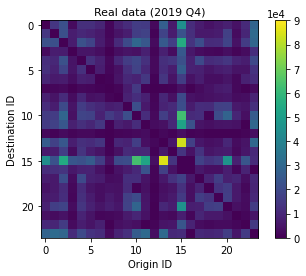

In [9]:
plt.imshow(ODb, vmin=0, vmax=9e4)
plt.xlabel('Origin ID')
plt.ylabel('Destination ID')
plt.title('Real data (2019 Q4)', fontsize=11)
plt.colorbar().formatter.set_powerlimits((0, 0))

# Gravity model

## Singly constrained

### Power law deterrence function

In [10]:
singly_fitted1 = Gravity(gravity_type='singly constrained')
print(singly_fitted1)

Gravity(name="Gravity model", deterrence_func_type="power_law", deterrence_func_args=[-2.0], origin_exp=1.0, destination_exp=1.0, gravity_type="singly constrained")


In [11]:
singly_fitted1.fit(fdf, relevance_column='population')
print(singly_fitted1)

Gravity(name="Gravity model", deterrence_func_type="power_law", deterrence_func_args=[-0.05156525318824635], origin_exp=1.0, destination_exp=0.6238832129240497, gravity_type="singly constrained")


In [12]:
fdf_fit1 = singly_fitted1.generate(tess, tile_id_column='tile_ID', tot_outflows_column='tot_outflow',
                                   relevance_column='population', out_format='flows')

100%|███████████████████████████████████████████████████████████████████████████████| 24/24 [00:00<00:00, 24110.97it/s]
E:\Program_Files\Anaconda\envs\skmob\lib\site-packages\skmob\models\gravity.py:43: RuntimeWarning: divide by zero encountered in power
  return np.power(x, exponent)


In [13]:
OD_fit1 = pd.DataFrame(fdf_fit1[['origin', 'destination', 'flow']])
OD_rec1 = OD_fit1.pivot(index='origin', columns='destination', values='flow').fillna(0)
OD_rec1.head()

destination,ATL,BOS,CHI,CLT,DEN,DFW,DTW,HNL,IAH,LAS,...,MSP,NYC,PHL,PHX,SAN,SEA,SFO,SLC,TPA,WAS
origin,,,,,,,,,,,,,,,,,,,,,
ATL,0.000000,15258.428638,17579.396899,8124.589592,8797.196874,14798.241382,11930.188630,3742.409133,13963.079625,6462.885505,...,9636.475049,29077.401490,14298.208178,10528.252796,8345.219291,10306.963752,16084.794955,7085.353505,8558.149960,17388.805020
BOS,12130.132850,0.000000,15713.315558,6979.000021,7868.252263,12978.447737,10867.679028,3394.453110,12209.579933,5807.566724,...,8696.314227,28726.352224,13621.570598,9418.315350,7487.799512,9334.348505,14489.276013,6370.231443,7385.849112,16111.931630
CHI,19966.765312,22449.973233,0.000000,11325.369324,13097.859845,21611.594913,18341.928086,5504.087273,20187.273919,9554.099804,...,14825.187313,42709.608955,20908.565696,15513.066554,12296.000584,15291.348000,23759.770009,10512.375668,11975.249586,25353.112041
CLT,5840.398531,6310.714082,7167.862778,0.000000,3568.765065,5960.935117,4905.258839,1524.415317,5618.319463,2625.211436,...,3925.156938,12064.407984,5955.642116,4270.844291,3388.452858,4195.671723,6538.317253,2878.505952,3454.340422,7277.051972
DEN,12774.562381,14372.232992,16745.507624,7209.059801,0.000000,14486.120945,11250.253851,3694.880084,13448.882528,6637.813756,...,9525.033948,27223.384844,13300.460292,10774.861860,8474.658569,10430.495691,16328.227649,7395.278280,7780.625917,16067.774965


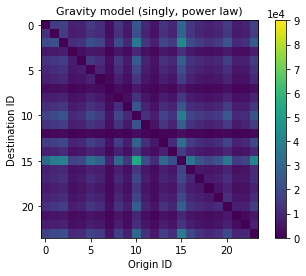

In [14]:
plt.imshow(OD_rec1, vmin=0, vmax=9e4)
plt.xlabel('Origin ID')
plt.ylabel('Destination ID')
plt.title('Gravity model (singly, power law)', fontsize=11)
plt.colorbar().formatter.set_powerlimits((0, 0))

### Exponential deterrence function

In [15]:
singly_fitted2 = Gravity(gravity_type='singly constrained', deterrence_func_type='exponential')
print(singly_fitted2)

Gravity(name="Gravity model", deterrence_func_type="exponential", deterrence_func_args=[-2.0], origin_exp=1.0, destination_exp=1.0, gravity_type="singly constrained")


In [16]:
singly_fitted2.fit(fdf, relevance_column='population')
print(singly_fitted2)

Gravity(name="Gravity model", deterrence_func_type="exponential", deterrence_func_args=[0.00011274633954644174], origin_exp=1.0, destination_exp=0.6149776849306317, gravity_type="singly constrained")


In [17]:
fdf_fit2 = singly_fitted2.generate(tess, tile_id_column='tile_ID', tot_outflows_column='tot_outflow',
                                   relevance_column='population', out_format='flows')

100%|███████████████████████████████████████████████████████████████████████████████| 24/24 [00:00<00:00, 12240.19it/s]


In [18]:
OD_fit2 = pd.DataFrame(fdf_fit2[['origin', 'destination', 'flow']])
OD_rec2 = OD_fit2.pivot(index='origin', columns='destination', values='flow').fillna(0)
OD_rec2.head()

destination,ATL,BOS,CHI,CLT,DEN,DFW,DTW,HNL,IAH,LAS,...,MSP,NYC,PHL,PHX,SAN,SEA,SFO,SLC,TPA,WAS
origin,,,,,,,,,,,,,,,,,,,,,
ATL,0.000000,15604.064242,18645.951196,8860.702905,8739.566910,15508.718201,12693.967933,2101.810566,14661.185876,5915.033345,...,9927.677277,30043.714815,15113.239565,9886.375126,7524.581402,8829.463567,13844.635548,6648.109437,9301.781398,18530.436264
BOS,13022.903768,0.000000,16950.379619,7746.247418,7570.158785,12785.667147,12104.801174,1834.207534,11914.040429,5088.014985,...,9144.425837,32023.870620,15448.088105,8321.127750,6360.254899,7990.571718,11970.456565,5799.274388,7735.375328,18171.019492
CHI,21148.674046,23036.045510,0.000000,12083.395457,13498.788982,22406.210918,19792.715578,3246.835532,20557.677647,9069.728464,...,16028.015029,44068.268489,21924.736062,14830.918841,11344.545717,13993.118462,21310.659807,10316.920630,12196.834253,26746.266089
CLT,6339.192412,6640.289616,7621.775410,0.000000,3485.540783,6115.957119,5276.431586,835.041173,5763.765813,2350.245708,...,4040.655594,12780.954305,6432.292606,3910.232496,2977.511296,3547.691456,5504.071956,2651.726433,3743.289096,7877.454347
DEN,12724.715447,13206.661752,17328.236850,7093.532737,0.000000,15438.699478,11351.892878,2553.534873,13982.207108,7166.438865,...,10176.948164,25254.853203,12578.363737,11594.066725,8931.806396,10687.073912,16818.209342,8113.454150,7472.951138,15373.894766


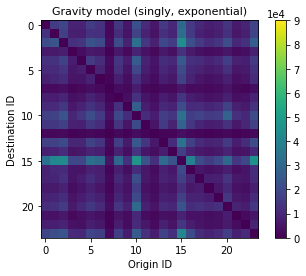

In [19]:
plt.imshow(OD_rec2, vmin=0, vmax=9e4)
plt.xlabel('Origin ID')
plt.ylabel('Destination ID')
plt.title('Gravity model (singly, exponential)', fontsize=11)
plt.colorbar().formatter.set_powerlimits((0, 0))

## Globally constrained gravity model

### Power law deterrence function

In [20]:
globally_fitted1 = Gravity(gravity_type='globally constrained')
print(globally_fitted1)

Gravity(name="Gravity model", deterrence_func_type="power_law", deterrence_func_args=[-2.0], origin_exp=1.0, destination_exp=1.0, gravity_type="globally constrained")


In [21]:
globally_fitted1.fit(fdf, relevance_column='population')
print(globally_fitted1)

Gravity(name="Gravity model", deterrence_func_type="power_law", deterrence_func_args=[-0.05304299232341293], origin_exp=0.6250187103023493, destination_exp=0.6220923578385958, gravity_type="globally constrained")


In [22]:
fdf_fit3 = globally_fitted1.generate(tess, tile_id_column='tile_ID', tot_outflows_column='tot_outflow',
                                     relevance_column='population', out_format='flows')

100%|███████████████████████████████████████████████████████████████████████████████| 24/24 [00:00<00:00, 24070.61it/s]
E:\Program_Files\Anaconda\envs\skmob\lib\site-packages\skmob\models\gravity.py:43: RuntimeWarning: divide by zero encountered in power
  return np.power(x, exponent)


In [23]:
OD_fit3 = pd.DataFrame(fdf_fit3[['origin', 'destination', 'flow']])
OD_rec3 = OD_fit3.pivot(index='origin', columns='destination', values='flow').fillna(0)
OD_rec3.head()

destination,ATL,BOS,CHI,CLT,DEN,DFW,DTW,HNL,IAH,LAS,...,MSP,NYC,PHL,PHX,SAN,SEA,SFO,SLC,TPA,WAS
origin,,,,,,,,,,,,,,,,,,,,,
ATL,0.000000,13431.018913,15479.268329,7181.010266,7752.572541,13032.276264,10515.934875,3298.684788,12299.096390,5696.806180,...,8493.666203,25555.569428,12595.390262,9269.230398,7350.141160,9070.209107,14137.431839,6244.872012,7555.927480,15314.143662
BOS,13439.648818,0.000000,17398.881968,7747.996039,8719.560509,14364.930047,12052.583823,3763.990601,13515.317321,6438.315673,...,9641.359671,31839.262103,15116.719113,10427.441718,8294.048032,10333.338586,16017.887239,7061.497047,8191.784799,17861.795094
CHI,15497.785766,17408.510204,0.000000,8804.626763,10171.759486,16762.974102,14260.649801,4273.823332,15656.627664,7419.939117,...,11526.012240,33065.957331,16222.753032,12032.333615,9540.830965,11857.206343,18398.955433,8164.200149,9300.671740,19664.723503
CLT,7161.961777,7722.481586,8770.779188,0.000000,4369.765499,7292.480054,6009.917912,1867.164007,6874.409135,3215.319115,...,4807.543747,14741.945768,7295.012640,5224.434533,4146.762833,5130.617053,7985.180862,3525.217411,4236.907222,8912.598153
DEN,7738.029446,8697.614911,10140.547357,4373.168583,0.000000,8780.483409,6817.953284,2242.086103,8149.532114,4032.588385,...,5779.898516,16446.502622,8052.261428,6537.454961,5142.723313,6323.554135,9887.863265,4494.390803,4718.005599,9723.370238


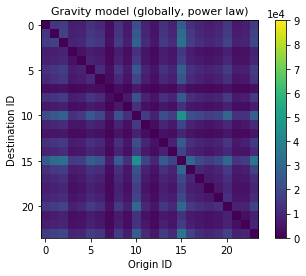

In [24]:
plt.imshow(OD_rec3, vmin=0, vmax=9e4)
plt.xlabel('Origin ID')
plt.ylabel('Destination ID')
plt.title('Gravity model (globally, power law)', fontsize=11)
plt.colorbar().formatter.set_powerlimits((0, 0))

### Exponential deterrence function

In [25]:
globally_fitted2 = Gravity(gravity_type='globally constrained', deterrence_func_type='exponential')
print(globally_fitted2)

Gravity(name="Gravity model", deterrence_func_type="exponential", deterrence_func_args=[-2.0], origin_exp=1.0, destination_exp=1.0, gravity_type="globally constrained")


In [26]:
globally_fitted2.fit(fdf, relevance_column='population')
print(globally_fitted2)

Gravity(name="Gravity model", deterrence_func_type="exponential", deterrence_func_args=[9.776271562665538e-05], origin_exp=0.6166892474685293, destination_exp=0.6136791775766628, gravity_type="globally constrained")


In [27]:
fdf_fit4 = globally_fitted2.generate(tess, tile_id_column='tile_ID', tot_outflows_column='tot_outflow',
                                     relevance_column='population', out_format='flows')

100%|███████████████████████████████████████████████████████████████████████████████| 24/24 [00:00<00:00, 23242.51it/s]


In [28]:
OD_fit4 = pd.DataFrame(fdf_fit4[['origin', 'destination', 'flow']])
OD_rec4 = OD_fit4.pivot(index='origin', columns='destination', values='flow').fillna(0)
OD_rec4.head()

destination,ATL,BOS,CHI,CLT,DEN,DFW,DTW,HNL,IAH,LAS,...,MSP,NYC,PHL,PHX,SAN,SEA,SFO,SLC,TPA,WAS
origin,,,,,,,,,,,,,,,,,,,,,
ATL,0.000000,14142.003486,16756.457861,7907.354986,7982.514713,13988.834346,11423.574845,2097.181456,13222.920930,5483.043792,...,9004.702118,27087.436773,13608.639288,9107.635715,6983.663834,8252.177954,12905.582408,6135.849115,8335.245457,16633.143511
BOS,14151.350264,0.000000,18379.230384,8384.170973,8396.400982,14096.794070,13060.291204,2220.233823,13159.528033,5732.619681,...,9990.080764,34107.649368,16523.980886,9344.290697,7191.601549,9016.161140,13553.442068,6493.544408,8462.998609,19482.561798
CHI,16777.076977,18389.692176,0.000000,9598.946767,10795.146933,17853.099591,15575.739121,2836.471638,16443.639363,7368.239390,...,12654.067372,35027.199197,17429.862805,12008.945714,9248.418162,11411.626520,17401.026321,8331.793364,9779.923484,21210.289129
CLT,7885.780539,8355.773056,9560.992008,0.000000,4458.512231,7737.312311,6613.444978,1167.459176,7293.975231,3052.555806,...,5118.831584,16000.093619,8041.582106,5050.350443,3874.159050,4638.960354,7188.416805,3427.429435,4691.982526,9818.850910
DEN,7967.112291,8374.664948,10761.075788,4462.083803,0.000000,9535.665681,7095.708953,1699.110245,8684.490346,4431.645264,...,6296.243107,15946.090488,7942.388224,7156.185499,5545.219043,6664.171953,10454.898149,4990.674285,4717.945776,9681.090193


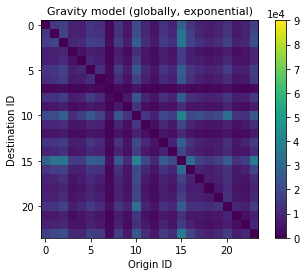

In [29]:
plt.imshow(OD_rec4, vmin=0, vmax=9e4)
plt.xlabel('Origin ID')
plt.ylabel('Destination ID')
plt.title('Gravity model (globally, exponential)', fontsize=11)
plt.colorbar().formatter.set_powerlimits((0, 0))